In [16]:
from albumentations import (ToFloat, 
    CLAHE, RandomRotate90, Transpose, ShiftScaleRotate, Blur, OpticalDistortion, 
    GridDistortion, HueSaturationValue, IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, 
    MedianBlur, IAAPiecewiseAffine, IAASharpen, IAAEmboss, RandomContrast, RandomBrightness, 
    Flip, OneOf, Compose,HorizontalFlip,VerticalFlip
)

In [17]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None, target_size=(256, 256), num_images_without_ship=20000):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.target_size = target_size

        # Filter images without ships
        images_with_ship = self.data[self.data['EncodedPixels'].notnull()]
        images_without_ship = self.data[self.data['EncodedPixels'].isnull()].sample(n=num_images_without_ship, random_state=42)

        # Concatenate the two subsets
        self.data = pd.concat([images_with_ship, images_without_ship], ignore_index=True)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data.iloc[idx, 0])
        image = io.imread(img_name)

        mask_str = self.data.iloc[idx, 1] 
        
        # Convert the mask string to a NumPy array
        mask = rle_decode(mask_str, target_size=self.target_size)

        # Resize both image and mask to the target size
        image = cv2.resize(image, self.target_size, interpolation=cv2.INTER_AREA)
        mask = cv2.resize(mask, self.target_size, interpolation=cv2.INTER_NEAREST)

        sample = {'image': image, 'mask': mask}

        if self.transform:
            # Pass data to augmentations using named arguments
            sample = self.transform(image=sample['image'], mask=sample['mask'])

        return sample

In [1]:
# Function to decode RLE-encoded masks to NumPy arrays
def rle_decode(mask_rle, target_size=(256, 256)):
    if pd.isna(mask_rle):  # Handle missing masks
        return np.zeros(target_size, dtype=np.uint8)

    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(np.prod(target_size), dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(target_size, order='F')

NameError: name 'A' is not defined

In [19]:
# Set your CSV file and root directory
csv_file = "C:\\Users\\Микола\Downloads\\airbus-ship-detection\\train_ship_segmentations_v2.csv"
root_dir = "C:\\Users\\Микола\\Downloads\\airbus-ship-detection\\train_v2"

# Create an instance of the dataset
custom_dataset = CustomDataset(csv_file=csv_file, root_dir=root_dir, transform=train_transforms)

# Calculate the index for splitting into train and validation sets
split_index = int(0.8 * len(custom_dataset))

# Create training and validation datasets
train_dataset, val_dataset = torch.utils.data.random_split(custom_dataset, [split_index, len(custom_dataset) - split_index])

In [20]:
# Create DataLoaders for training and validation datasets
batch_size = 16 
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

In [21]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        # Encoder
        self.enc1 = self.conv_block(in_channels, 8)
        self.enc2 = self.conv_block(8, 16)
        self.enc3 = self.conv_block(16, 32)

        # Bottleneck
        self.bottleneck = self.conv_block(32, 64)

        # Decoder
        self.dec3 = self.conv_block(64, 32)
        self.dec2 = self.conv_block(32, 16)
        self.dec1 = self.final_conv_block(16, out_channels)

        # UpSampling
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)

        # Bottleneck
        bottleneck = self.bottleneck(enc3)

        # Decoder
        dec3 = self.dec3(bottleneck)
        dec2 = self.dec2(dec3)
        dec1 = self.dec1(dec2)

        # Upsample
        dec1 = self.upsample(dec1)

        return torch.sigmoid(dec1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True))

    def final_conv_block(self, in_channels, out_channels):
        return nn.Conv2d(in_channels, out_channels, kernel_size=1)

in_channels = 3 
out_channels = 1  
unet_model = UNet(in_channels, out_channels)

# Print the model architecture
print(unet_model)

# Move the model to GPU if available
device = torch.device("cuda:0")
assert torch.cuda.is_available(), "CUDA is not available on this machine."
unet_model = unet_model.to(device)

# Define loss function and optimizer
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(unet_model.parameters(), lr=1e-4, weight_decay=1e-6)

# Training loop
NB_EPOCHS = 7
for epoch in range(NB_EPOCHS):
    unet_model.train()
    for batch in train_loader:
        inputs, targets = batch['image'].to(device), batch['mask'].to(device)

        # Forward pass
        outputs = unet_model(inputs)

        # Resize targets to match the output size of the model
        targets = F.interpolate(targets.unsqueeze(1), size=outputs.shape[2:], mode='nearest').squeeze(1)

        # Ensure targets have a channel dimension of 1
        targets = targets.unsqueeze(1)

        # Compute loss
        loss = criterion(outputs, targets.float())

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch + 1}/{NB_EPOCHS}, Loss: {loss.item()}')

UNet(
  (enc1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (enc2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (enc3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (bottleneck): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dec3): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3),

KeyboardInterrupt: 

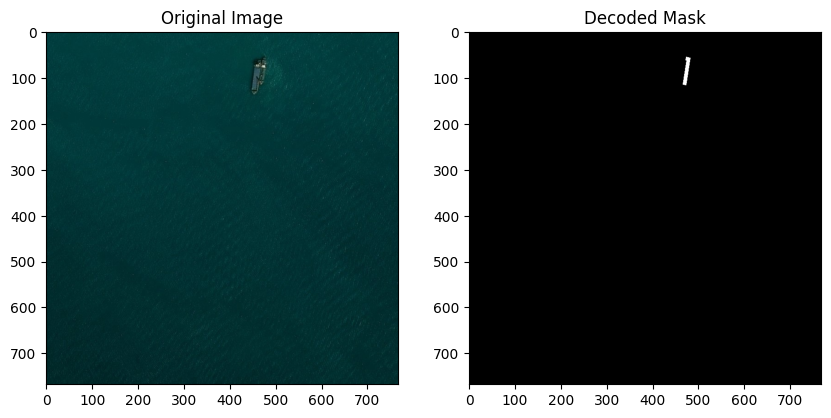

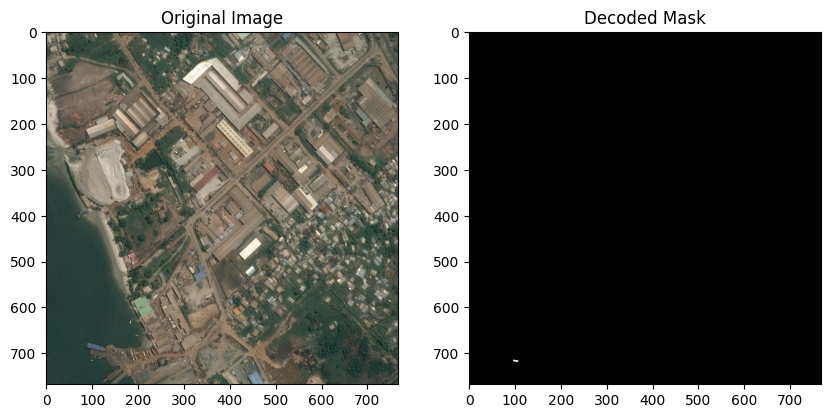

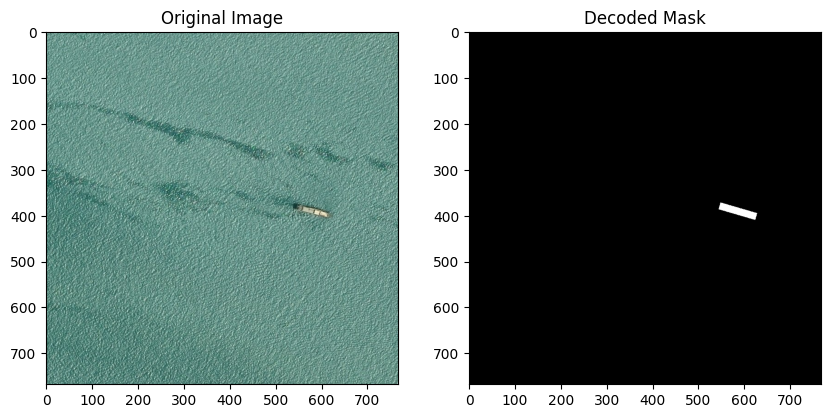

UNet(
  (enc1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (enc2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (enc3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (bottleneck): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dec3): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3),

KeyboardInterrupt: 

In [1]:
import os
import pandas as pd
import numpy as np
from skimage import io
import torch
import matplotlib.pyplot as plt
import random
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import cv2
from torch.utils.tensorboard import SummaryWriter

class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir, target_size=(768, 768), ship_ratio=0.8):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.target_size = target_size

        # Filter images without ships
        images_with_ship = self.data[self.data['EncodedPixels'].notnull()]
        num_images_with_ship = len(images_with_ship)

        # Calculate the number of images without ships dynamically
        num_images_without_ship = int(num_images_with_ship / ship_ratio) - num_images_with_ship

        # Ensure at least one image without ships is included
        num_images_without_ship = max(num_images_without_ship, 1)

        # Sample images without ships without replacement
        images_without_ship = self.data[self.data['EncodedPixels'].isnull()].sample(
            n=num_images_without_ship, random_state=42, replace=False)

        self.data = pd.concat([images_with_ship, images_without_ship], ignore_index=True)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data.iloc[idx, 0])
        image = io.imread(img_name)

        mask_str = self.data.iloc[idx, 1]  # Adapt this based on your actual column

        # Convert the mask string to a NumPy array
        mask = rle_decode(mask_str, target_size=self.target_size)

        sample = {'image': image, 'mask': mask}

        return sample

# Function to decode RLE-encoded masks to NumPy arrays
def rle_decode(mask_rle, target_size=(768, 768)):
    if pd.isna(mask_rle):  # Handle missing masks
        return np.zeros(target_size, dtype=np.uint8)

    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(np.prod(target_size), dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(target_size, order='F')

csv_file = "C:\\Users\\Микола\Downloads\\airbus-ship-detection\\copied_images.csv"
root_dir = "C:\\Users\\Микола\\Downloads\\airbus-ship-detection\\train_v400"

custom_dataset = CustomDataset(csv_file=csv_file, root_dir=root_dir)

# Select indices where both ships and masks are present
indices_with_ships = custom_dataset.data[custom_dataset.data['EncodedPixels'].notnull()].index.tolist()
sample_indices = random.sample(indices_with_ships, 3)  # Select 3 random samples

# Plot the original image and its decoded mask
for idx in sample_indices:
    sample = custom_dataset[idx]

    original_image = sample['image']
    mask = sample['mask']

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title('Original Image')

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray', vmin=0, vmax=1)
    plt.title('Decoded Mask')

    plt.show()

# Calculate the index for splitting into train and validation sets
split_index = int(0.8 * len(custom_dataset))

# Create training and validation datasets
train_dataset, val_dataset = torch.utils.data.random_split(custom_dataset, [split_index, len(custom_dataset) - split_index])

# Create DataLoaders for training and validation datasets
batch_size = 16 
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        # Encoder
        self.enc1 = self.conv_block(in_channels, 8)
        self.enc2 = self.conv_block(8, 16)
        self.enc3 = self.conv_block(16, 32)

        # Bottleneck
        self.bottleneck = self.conv_block(32, 64)

        # Decoder
        self.dec3 = self.conv_block(64, 32)
        self.dec2 = self.conv_block(32, 16)
        self.dec1 = self.final_conv_block(16, out_channels, activation='sigmoid') 

        # UpSampling
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self, x):
            # Transpose input data to have channels as the first dimension
            x = x.permute(0, 3, 1, 2) 

            # Move input to GPU and convert to float explicitly
            x = x.to(device, dtype=torch.float)

            # Encoder
            enc1 = self.enc1(x)
            enc2 = self.enc2(enc1)
            enc3 = self.enc3(enc2)

            # Bottleneck
            bottleneck = self.bottleneck(enc3)

            # Decoder
            dec3 = self.dec3(bottleneck)
            dec2 = self.dec2(dec3)
            dec1 = self.dec1(dec2)

            # Upsample
            dec1 = self.upsample(dec1)

            return torch.sigmoid(dec1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True))

    def final_conv_block(self, in_channels, out_channels, activation=None):
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=1)]
        if activation:
            layers.append(nn.Sigmoid() if activation == 'sigmoid' else nn.ReLU(inplace=True))
        return nn.Sequential(*layers)
    
in_channels = 3  
out_channels = 1  
unet_model = UNet(in_channels, out_channels)

print(unet_model)

# Move the model to GPU if available
device = torch.device("cuda:0")
assert torch.cuda.is_available(), "CUDA is not available on this machine."
unet_model = unet_model.to(device)

# Define loss function and optimizer
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(unet_model.parameters(), lr=1e-4, weight_decay=1e-6)

# Create a SummaryWriter instance
writer = SummaryWriter()

# Training loop
NB_EPOCHS = 10
for epoch in range(NB_EPOCHS):
    unet_model.train()
    total_loss = 0.0
    total_dice = 0.0
    total_batches = 0

    for batch in train_loader:
        inputs, targets = batch['image'].to(device), batch['mask'].to(device)

        # Forward pass
        outputs = unet_model(inputs)

        # Resize targets to match the output size of the model
        targets_resized = F.interpolate(targets.unsqueeze(1), size=outputs.shape[2:], mode='nearest').squeeze(1)

        # Ensure targets have a channel dimension of 1
        targets_resized = targets_resized.unsqueeze(1)

        # Resize predicted masks to match the size of targets
        outputs_resized = F.interpolate(outputs, size=targets_resized.shape[2:], mode='bilinear', align_corners=False)

        # Calculate dynamic threshold using Otsu method
        threshold = 0.5 
        for i in range(outputs_resized.shape[0]):
            img = outputs_resized[i, 0].cpu().detach().numpy()

            # Convert the image to the appropriate type for Otsu thresholding
            img_for_otsu = (img * 255).astype(np.uint8)

            _, img_threshold = cv2.threshold(img_for_otsu, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

            # Convert the thresholded image back to the range [0, 1]
            img_threshold = img_threshold / 255.0

            threshold += img_threshold.mean().item()

        threshold /= outputs_resized.shape[0]

        # Binarize predicted masks using the dynamic threshold
        predicted_masks = outputs_resized > threshold

        # Calculate DICE score
        intersection = (predicted_masks & targets_resized.byte()).float().sum()
        union = (predicted_masks | targets_resized.byte()).float().sum()
        dice = (2.0 * intersection) / (union + 1e-8) 
        total_dice += dice.item()

        # Compute loss
        loss = criterion(outputs, targets_resized.float())
        total_loss += loss.item()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_batches += 1

    average_loss = total_loss / total_batches
    average_dice = total_dice / total_batches

    print(f'Epoch {epoch + 1}/{NB_EPOCHS}, Loss: {average_loss}, DICE: {average_dice}')

    # Log metrics to TensorBoard
    writer.add_scalar('Train/Loss', average_loss, epoch)
    writer.add_scalar('Train/DICE', average_dice, epoch)

writer.close()

In [ ]:
# Check Target Masks
for batch in train_loader:
    targets = batch['mask'].to(device)
    print("Check Target Masks:")
    print("Target Mask Values:", targets[0].cpu().numpy())
    break

# Check Predicted Masks Before Binarization
for batch in train_loader:
    inputs, targets = batch['image'].to(device), batch['mask'].to(device)
    outputs = unet_model(inputs)
    targets_resized = F.interpolate(targets.unsqueeze(1), size=outputs.shape[2:], mode='nearest').squeeze(1)

    # Ensure the spatial dimensions of outputs_resized match targets_resized
    outputs_resized = F.interpolate(outputs, size=targets_resized.shape[2:], mode='bilinear', align_corners=False)

    print("\nCheck Predicted Masks Before Binarization:")
    print("Targets Resized Shape:", targets_resized.shape)
    print("Outputs Resized Shape:", outputs_resized.shape)

    print("Predicted Mask Values (Before Binarization):", outputs_resized[0].cpu().numpy().squeeze())
    break

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None, target_size=(256, 256), ship_ratio=0.8):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.target_size = target_size

        # Filter images without ships
        images_with_ship = self.data[self.data['EncodedPixels'].notnull()]
        num_images_with_ship = len(images_with_ship)

        # Calculate the number of images without ships dynamically
        num_images_without_ship = int(num_images_with_ship / ship_ratio) - num_images_with_ship

        # Ensure at least one image without ships is included
        num_images_without_ship = max(num_images_without_ship, 1)

        # Sample images without ships without replacement
        images_without_ship = self.data[self.data['EncodedPixels'].isnull()].sample(
            n=num_images_without_ship, random_state=42, replace=False)
        
        self.data = pd.concat([images_with_ship, images_without_ship], ignore_index=True)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data.iloc[idx, 0])
        image = io.imread(img_name)
        mask_str = self.data.iloc[idx, 1]
        
        # Dynamically set the target size based on the input image size
        target_size = (image.shape[0], image.shape[1])

        mask = rle_decode(mask_str, target_size=target_size)
        image = cv2.resize(image, target_size, interpolation=cv2.INTER_AREA)
        mask = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)
        sample = {'image': image, 'mask': mask}

        if self.transform:
            sample = self.transform(image=sample['image'], mask=sample['mask'])

        return sample

# Function to decode RLE-encoded masks to NumPy arrays
def rle_decode(mask_rle, target_size=(256, 256)):
    if pd.isna(mask_rle):  # Handle missing masks
        return np.zeros(target_size, dtype=np.uint8)

    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(np.prod(target_size), dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(target_size, order='F')

# Define Albumentations transforms
train_transforms = A.Compose([
    A.Resize(256, 256),
    A.Flip(),
    A.RandomRotate90(),
    A.HorizontalFlip(),
    A.VerticalFlip(),
    A.RandomCrop(256, 256),
    A.ToFloat(),
    ToTensorV2()])

In [ ]:

plt.subplot(1, 3, 1)
plt.imshow(original_image)
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(ground_truth_mask, cmap='gray', vmin=0, vmax=1)
plt.title('Ground Truth Mask')

In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

unet_model.eval()

input_image = Image.open('C:\\Users\\Микола\\Downloads\\airbus-ship-detection\\0006c52e8.jpg')

input_image = input_image.convert("RGB")

print("Input Image Channels:", len(input_image.getbands()))

# Preprocess the input image for visualization 
# Converts the image to a tensor with 3 channels
transform_visualization = transforms.Compose([
    transforms.Resize((768, 768)),
    transforms.ToTensor(),])

input_image_visualization = transform_visualization(input_image).permute(1, 2, 0)

print("Input Image Shape (Visualization):", input_image_visualization.shape)

# Ensure the input has 3 channels
if input_image_visualization.shape[2] != 3:
    raise ValueError(f"Expected 3 channels, but got {input_image_visualization.shape[2]} channels.")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(input_image_visualization.numpy())
plt.title('Input Image')

# Converts the image to a tensor with 3 channels
# Preprocess the input image for prediction
transform_prediction = transforms.Compose([
    transforms.Resize((768, 768)),
    transforms.ToTensor(),])

input_image_prediction = transform_prediction(input_image).permute(1, 2, 0)

# Normalize the input image for prediction to the range [0, 1]
input_image_prediction = input_image_prediction / 255.0

print("Input Image Shape (Prediction):", input_image_prediction.shape)

# Ensure the input has 3 channels
if input_image_prediction.shape[2] != 3:
    raise ValueError(f"Expected 3 channels, but got {input_image_prediction.shape[2]} channels.")

with torch.no_grad():
    print("Input Image Shape Before Unsqueeze:", input_image_prediction.shape)
    predicted_mask = unet_model(input_image_prediction.unsqueeze(0))
    print("Predicted Mask Shape:", predicted_mask.shape)

print("Predicted Mask Shape:", predicted_mask.shape)

# Perform post-processing (thresholding)
threshold = 0.5
predicted_mask_binary = (predicted_mask > threshold).float()

# Convert the tensor to a numpy array for visualization
predicted_mask_np = predicted_mask_binary.squeeze().cpu().numpy()

plt.subplot(1, 2, 2)
plt.imshow(predicted_mask_np, cmap='gray', vmin=0, vmax=1)
plt.title('Predicted Mask')

plt.show()


In [6]:
########################################################################DONT WORK 
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0

    for batch in train_loader:
        inputs, targets = batch['image'].to(device), batch['mask'].to(device)

        optimizer.zero_grad()

        outputs = model(inputs.unsqueeze(1).float())  # Add channel dimension for the grayscale mask
        loss = criterion(outputs, targets.unsqueeze(1).float())

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    average_loss = running_loss / len(train_loader)
    return average_loss

def evaluate_model(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_dice = 0.0

    with torch.no_grad():
        for batch in val_loader:
            inputs, targets = batch['image'].to(device), batch['mask'].to(device)
            
            # Add channel dimension for the grayscale mask
            outputs = model(inputs.unsqueeze(1).float()) 
            loss = criterion(outputs, targets.unsqueeze(1).float())

            dice = dice_coefficient(torch.sigmoid(outputs), targets.unsqueeze(1))

            running_loss += loss.item()
            running_dice += dice.item()

    average_loss = running_loss / len(val_loader)
    average_dice = running_dice / len(val_loader)
    return average_loss, average_dice

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    # Training
    train_loss = train_model(unet_model, train_loader, criterion, optimizer, device)

    # Validation
    val_loss, val_dice = evaluate_model(unet_model, val_loader, criterion, device)

    print(f'Epoch [{epoch + 1}/{num_epochs}], 'f'Training Loss: {train_loss:.4f}, 'f'Validation Loss: {val_loss:.4f}, 'f'Validation Dice: {val_dice:.4f}')

print(f'Training finished! Last Epoch [{epoch + 1}/{num_epochs}], 'f'Training Loss: {train_loss:.4f}, 'f'Validation Loss: {val_loss:.4f}, 'f'Validation Dice: {val_dice:.4f}')


RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 5 is not equal to len(dims) = 4

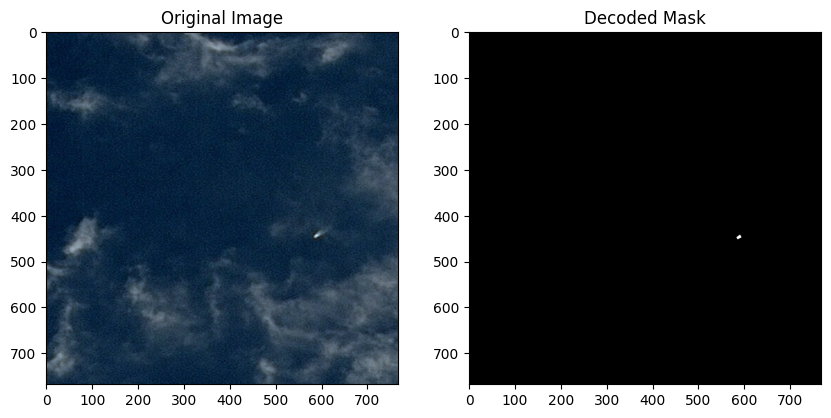

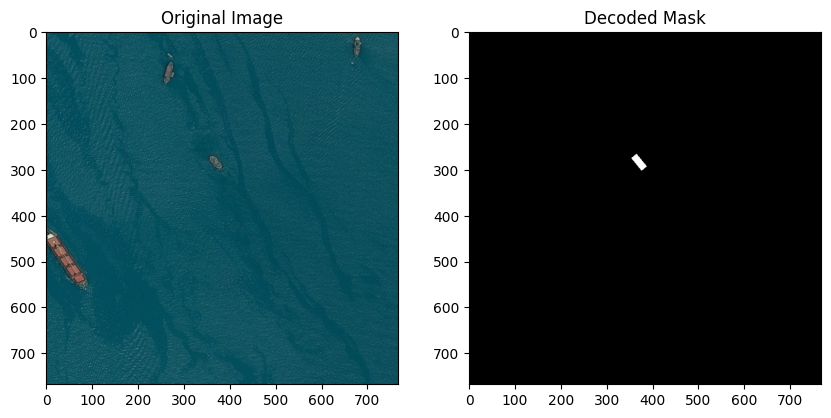

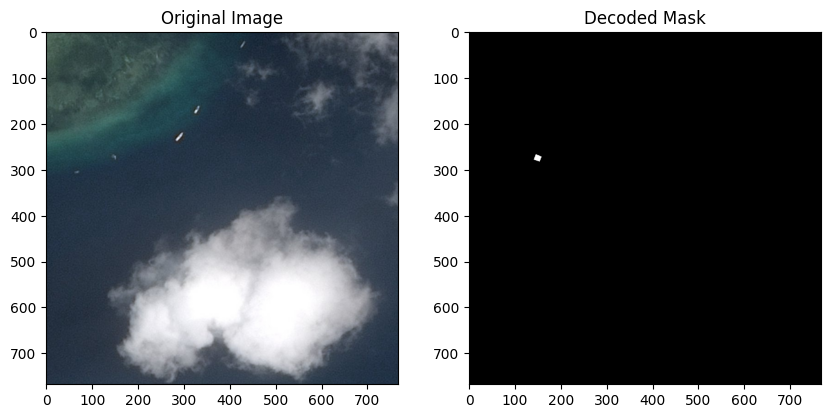

In [5]:
import os
import pandas as pd
import numpy as np
from skimage import io
import torch
import matplotlib.pyplot as plt
import random
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import cv2
from torchvision import transforms
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir, target_size=(768, 768), ship_ratio=0.5):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.target_size = target_size

        # Filter images without ships
        images_with_ship = self.data[self.data['EncodedPixels'].notnull()]
        num_images_with_ship = len(images_with_ship)

        # Calculate the number of images without ships dynamically
        num_images_without_ship = int(num_images_with_ship / ship_ratio) - num_images_with_ship

        # Ensure at least one image without ships is included
        num_images_without_ship = max(num_images_without_ship, 1)

        # Sample images without ships without replacement
        images_without_ship = self.data[self.data['EncodedPixels'].isnull()].sample(
            n=num_images_without_ship, random_state=42, replace=False)

        self.data = pd.concat([images_with_ship, images_without_ship], ignore_index=True)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data.iloc[idx, 0])
        image = io.imread(img_name)

        mask_str = self.data.iloc[idx, 1]  

        # Convert the mask string to a NumPy array
        mask = rle_decode(mask_str, target_size=self.target_size)

        sample = {'image': image, 'mask': mask}
        return sample

# Select indices where both ships and masks are present
indices_with_ships = custom_dataset.data[custom_dataset.data['EncodedPixels'].notnull()].index.tolist()
sample_indices = random.sample(indices_with_ships, 3) 

# Plot the original image and its decoded mask
for idx in sample_indices:
    sample = custom_dataset[idx]

    original_image = sample['image']
    decoded_mask = sample['mask']

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title('Original Image')

    plt.subplot(1, 2, 2)
    plt.imshow(decoded_mask, cmap='gray', vmin=0, vmax=1)
    plt.title('Decoded Mask')

    plt.show()

# Function to decode RLE-encoded masks to NumPy arrays
def rle_decode(mask_rle, target_size=(768, 768)):
    if pd.isna(mask_rle):  # Handle missing masks
        return np.zeros(target_size, dtype=np.uint8)

    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(np.prod(target_size), dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(target_size, order='F')

csv_file = "C:\\Users\\Микола\Downloads\\airbus-ship-detection\\copied_images.csv"
root_dir = "C:\\Users\\Микола\\Downloads\\airbus-ship-detection\\train_v400"

custom_dataset = CustomDataset(csv_file=csv_file, root_dir=root_dir)

# Calculate the index for splitting into train and validation sets
split_index = int(0.8 * len(custom_dataset))

# Create training and validation datasets
train_dataset, val_dataset = torch.utils.data.random_split(custom_dataset, [split_index, len(custom_dataset) - split_index])

# Create DataLoaders for training and validation datasets
batch_size = 32  # Reduce batch size
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
    def __build_mask__(self, idx):
        img_path = os.path.join(self.root_dir, self.data.iloc[idx, 0])
        image1 = io.imread(img_path)

        mask_str = self.data.iloc[idx, 1]

        # Convert the mask string to a NumPy array
        decoded_mask = rle_decode(mask_str, target_size=self.target_size)

        sample1 = {'image1': image, 'mask': decoded_mask}
        return sample1

# Select indices where both ships and masks are present
indices_with_ships = custom_dataset.data[custom_dataset.data['EncodedPixels'].notnull()].index.tolist()
sample_indices = random.sample(indices_with_ships, 3)  

# Plot the original image and its decoded mask
for idx in sample_indices:
    sample1 = custom_dataset[idx]

    original_image = sample1['image']
    decoded_mask = sample1['mask']

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title('Original Image')

    plt.subplot(1, 2, 2)
    plt.imshow(decoded_mask, cmap='gray', vmin=0, vmax=1)
    plt.title('Decoded Mask')

    plt.show()

In [ ]:

# def plot_examples(dataset, num_examples=3):
#     plt.figure(figsize=(15, 5))

#     for i in range(num_examples):
#         idx = random.randint(0, len(dataset) - 1)
        
#         # Get the sample from the dataset
#         sample = dataset[idx]
        
#         image = sample['image'].numpy().transpose(1, 2, 0)
#         mask = sample['mask'].numpy().squeeze()

#         plt.subplot(num_examples, 2, 2 * i + 1)
#         plt.imshow(image)
#         plt.axis('off')
#         plt.title('Image')

#         plt.subplot(num_examples, 2, 2 * i + 2)
#         plt.imshow(mask, cmap='gray')
#         plt.axis('off')
#         plt.title('Mask')

#     plt.show()

# plot_examples(train_dataset, num_examples=3)



In [ ]:
UNet(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (upconv4): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
    (1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
  )
  (upconv3): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2))
    (1): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU(inplace=True)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
  )
  (upconv2): Sequential(
    (0): ConvTranspose2d(16, 8, kernel_size=(2, 2), stride=(2, 2))
    (1): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU(inplace=True)
    (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
  )
  (upconv1): Sequential(
    (0): ConvTranspose2d(8, 8, kernel_size=(2, 2), stride=(2, 2))
    (1): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU(inplace=True)
    (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
  )
  (final_conv): Conv2d(8, 1, kernel_size=(1, 1), stride=(1, 1))
)

In [ ]:
    def __getitem__(self, idx):
        mask_str = self.data.iloc[idx, self.data.columns.get_loc('EncodedPixels')]  

        # Convert the mask string to a NumPy array
        mask = rle_decode(mask_str, target_size=self.target_size)

        # Convert the mask to a PIL image
        mask = Image.fromarray(mask)

        # Apply transformations to convert to tensors
        transform = transforms.Compose([
            transforms.ToTensor(),])

        image = transform(image)
        mask = transform(mask)

        # Increase the number of channels to 64
        image = F.interpolate(image.unsqueeze(0), size=(96, 96), mode='bilinear', align_corners=False)
        mask = F.interpolate(mask.unsqueeze(0), size=(96, 96), mode='bilinear', align_corners=False)

        # Repeat along the channel dimension to have 64 channels
        image = image.repeat(1, 64, 1, 1)
        mask = mask.repeat(1, 64, 1, 1)

        sample = {'image': image, 'mask': mask}

        print("Sample:", sample)  

        return sample

In [11]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        # Mid-level
        self.mid = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 3, kernel_size=2, stride=2))

    def forward(self, x):
        # Encoder
        x1 = self.encoder(x)
        
        # Mid-level
        x2 = self.mid(x1)
        
        # Decoder
        x3 = self.decoder(x2)
        
        return x3

model = UNet()
print(model)

UNet(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (mid): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(64, 3, kernel_size=(2, 2), stride=(2, 2))
  )
)


In [2]:
import os
import pandas as pd
import numpy as np
from skimage import io
import torch
import matplotlib.pyplot as plt
import random
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import cv2
from torchvision import transforms
from PIL import Image
import torch.optim as optim
from tqdm import tqdm

class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir, target_size=(768, 768), ship_ratio=0.8):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.target_size = target_size

        # Filter images without ships
        images_with_ship = self.data[self.data['EncodedPixels'].notnull()]
        num_images_with_ship = len(images_with_ship)

        # Calculate the number of images without ships dynamically
        num_images_without_ship = int(num_images_with_ship / ship_ratio) - num_images_with_ship

        # Ensure at least one image without ships is included
        num_images_without_ship = max(num_images_without_ship, 1)

        # Sample images without ships without replacement
        images_without_ship = self.data[self.data['EncodedPixels'].isnull()].sample(
            n=num_images_without_ship, random_state=42, replace=False)

        self.data = pd.concat([images_with_ship, images_without_ship], ignore_index=True)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data.iloc[idx, self.data.columns.get_loc('ImageId')])

        try:
            image = Image.open(img_name).convert('RGB')
            image = image.resize(self.target_size)

            mask_str = self.data.iloc[idx, self.data.columns.get_loc('EncodedPixels')] 

            # Convert the mask string to a NumPy array
            mask = rle_decode(mask_str, target_size=self.target_size)

            # Convert the mask to a PIL image
            mask = Image.fromarray(mask)

            # Apply transformations to convert to tensors
            transform = transforms.Compose([
                transforms.ToTensor()])

            image = transform(image)
            mask = transform(mask)

            sample = {'image': image, 'mask': mask}

            print("Sample:", sample)  

            return sample

        except Exception as e:
            print(f"Error: {str(e)} Could not load image at {img_name}")
            return None 


# Function to decode RLE-encoded masks to NumPy arrays
def rle_decode(mask_rle, target_size=(768, 768)):
    if pd.isna(mask_rle): 
        return np.zeros(target_size, dtype=np.uint8)

    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(np.prod(target_size), dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(target_size, order='F')

csv_file = "C:\\Users\\Микола\Downloads\\airbus-ship-detection\\copied_images.csv"
root_dir = "C:\\Users\\Микола\\Downloads\\airbus-ship-detection\\train_v400"

# Create an instance of the dataset
custom_dataset = CustomDataset(csv_file=csv_file, root_dir=root_dir)

# Calculate the index for splitting into train and validation sets
split_index = int(0.8 * len(custom_dataset))

# Create training and validation datasets
train_dataset, val_dataset = torch.utils.data.random_split(custom_dataset, [split_index, len(custom_dataset) - split_index])

# Create DataLoaders for training and validation datasets
batch_size = 8  
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)


In [3]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Downsampling path
        self.conv1 = self.conv_block(3, 8)
        self.conv2 = self.conv_block(8, 16)
        self.conv3 = self.conv_block(16, 32)
        self.conv4 = self.conv_block(32, 64)

        # Upsampling path
        self.upconv4 = self.upconv_block(64, 32)
        self.upconv3 = self.upconv_block(32, 16)
        self.upconv2 = self.upconv_block(16, 8)
        self.upconv1 = self.upconv_block(8, 8)

        # Final convolutional layer
        self.final_conv = nn.Conv2d(8, 1, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2))

    def upconv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.Conv2d(out_channels * 2, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True))

    def forward(self, x):
        # Downsampling
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        x4 = self.conv4(x3)

        # Upsampling
        x = self.upconv4(x4)
        x = self.upconv3(torch.cat([x, x3], dim=1))
        x = self.upconv2(torch.cat([x, x2], 1))
        x = self.upconv1(torch.cat([x, x1], 1))

        # Final convolutional layer
        self.final_conv = nn.Conv2d(8, 1, kernel_size=1)

        return x
    
model = UNet()
print(model)

# Sample input
batch_size = 8
input_channels = 3
input_height = 768
input_width = 768
sample_input = torch.randn((batch_size, input_channels, input_height, input_width))

# Forward pass
output_conv1 = model.conv1(sample_input)
output_conv2 = model.conv2(output_conv1)
output_conv3 = model.conv3(output_conv2)
output_conv4 = model.conv4(output_conv3)

# Upsampling and convolution
output_upconv4 = model.upconv4(output_conv4)
output_upconv3 = model.upconv3(output_upconv4 + output_conv3)  # Skip connection
output_upconv2 = model.upconv2(output_upconv3 + output_conv2)  # Skip connection
output_upconv1 = model.upconv1(output_upconv2 + output_conv1)  # Skip connection

# Final convolution
output_final = model.final_conv(output_upconv1)

print("Output Shape conv1:", output_conv1.shape)
print("Output Shape conv2:", output_conv2.shape)
print("Output Shape conv3:", output_conv3.shape)
print("Output Shape conv4:", output_conv4.shape)
print("Output Shape upconv4:", output_upconv4.shape)
print("Output Shape upconv3:", output_upconv3.shape)
print("Output Shape upconv2:", output_upconv2.shape)
print("Output Shape upconv1:", output_upconv1.shape)
print("Output Shape final:", output_final.shape)

UNet(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, k

RuntimeError: Given groups=1, weight of size [32, 64, 3, 3], expected input[8, 32, 96, 96] to have 64 channels, but got 32 channels instead

In [ ]:
import os
import pandas as pd
import numpy as np
from skimage import io
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import cv2
from torchvision import transforms
from PIL import Image
import torch.optim as optim
from tqdm import tqdm

class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir, target_size=(768, 768), ship_ratio=0.5):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.target_size = target_size

        # Filter images without ships
        images_with_ship = self.data[self.data['EncodedPixels'].notnull()]
        num_images_with_ship = len(images_with_ship)

        # Calculate the number of images without ships dynamically
        num_images_without_ship = int(num_images_with_ship / ship_ratio) - num_images_with_ship

        # Ensure at least one image without ships is included
        num_images_without_ship = max(num_images_without_ship, 1)

        # Sample images without ships without replacement
        images_without_ship = self.data[self.data['EncodedPixels'].isnull()].sample(
            n=num_images_without_ship, random_state=42, replace=False)

        # Concatenate the two subsets
        self.data = pd.concat([images_with_ship, images_without_ship], ignore_index=True)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data.iloc[idx, self.data.columns.get_loc('ImageId')])

        try:
            image = Image.open(img_name).convert('RGB')
            image = image.resize(self.target_size)

            mask_str = self.data.iloc[idx, self.data.columns.get_loc('EncodedPixels')]  

            # Convert the mask string to a NumPy array
            mask = rle_decode(mask_str, target_size=self.target_size)

            # Convert the mask to a PIL image
            mask = Image.fromarray(mask)

            # Apply transformations to convert to tensors
            transform = transforms.Compose([
                transforms.ToTensor(),])

            image = transform(image)
            mask = transform(mask)

            sample = {'image': image, 'mask': mask}

            # print("Sample:", sample)  

            return sample

        except Exception as e:
            print(f"Error: {str(e)} Could not load image at {img_name}")
            return None  


# Function to decode RLE-encoded masks to NumPy arrays
def rle_decode(mask_rle, target_size=(768, 768)):
    if pd.isna(mask_rle):  # Handle missing masks
        return np.zeros(target_size, dtype=np.uint8)

    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(np.prod(target_size), dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(target_size, order='F')

csv_file = "C:\\Users\\Микола\\Downloads\\airbus-ship-detection\\train_ship_segmentations_v2.csv"
root_dir = "C:\\Users\\Микола\\Downloads\\airbus-ship-detection\\train_v2"

# Create an instance of the dataset
custom_dataset = CustomDataset(csv_file=csv_file, root_dir=root_dir)

# Calculate the index for splitting into train and validation sets
split_index = int(0.8 * len(custom_dataset))

# Create training and validation datasets
train_dataset, val_dataset = torch.utils.data.random_split(custom_dataset, [split_index, len(custom_dataset) - split_index])

# Create DataLoaders for training and validation datasets
batch_size = 16  
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Downsampling path
        self.conv1 = self.conv_block(3, 8)
        self.conv2 = self.conv_block(8, 16)
        self.conv3 = self.conv_block(16, 32)
        self.conv4 = self.conv_block(32, 64)

        # Upsampling path
        self.upconv4 = self.upconv_block(64, 32)
        self.upconv3 = self.upconv_block(32, 16, skip_channels=32)
        self.upconv2 = self.upconv_block(16, 8, skip_channels=16)
        self.upconv1 = self.upconv_block(8, 8, skip_channels=8)

        # Final convolutional layer
        self.final_conv = nn.Conv2d(8, 1, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2))

    def upconv_block(self, in_channels, out_channels, skip_channels=0):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels + skip_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True))

    def forward(self, x):
        # Downsampling
        x1 = self.conv1(x)
        # print("Shape after conv1:", x1.shape)
        x2 = self.conv2(x1)
        # print("Shape after conv2:", x2.shape)
        x3 = self.conv3(x2)
        # print("Shape after conv3:", x3.shape)
        x4 = self.conv4(x3)
        # print("Shape after conv4:", x4.shape)

        # Upsampling with skip connections
        x = self.upconv4(x4)
        # print("Shape after upconv4:", x.shape)
        x = self.upconv3(torch.cat([x, x3], dim=1)) 
        # print("Shape after upconv3:", x.shape)
        x = self.upconv2(torch.cat([x, x2], dim=1))  
        # print("Shape after upconv2:", x.shape)
        x = self.upconv1(torch.cat([x, x1], dim=1))  
        # print("Shape after upconv1:", x.shape)

        # Final convolutional layer
        x = self.final_conv(x)
        # print("Shape after final_conv:", x.shape)
        return x

model = UNet()
# print(model)

# Sample input
batch_size = 8
input_channels = 3
input_height = 768
input_width = 768
sample_input = torch.randn((batch_size, input_channels, input_height, input_width))

# Forward pass
output_conv = model(sample_input)

# # Final convolution
# output_final = model.final_conv(output_upconv1)

# Define the Dice Score function
def dice_score(pred, target, smooth=1.0):
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return dice.item()

# Move the model to GPU if available
device = torch.device("cuda:0")
assert torch.cuda.is_available(), "CUDA is not available on this machine."
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  ####################### change? 
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    total_dice = 0.0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
        images = batch['image'].to(device)
        masks = batch['mask'].to(device)

        # Explicitly send the input tensor to the GPU
        images = images.to(device)
        
        # print("Batch Shape:", images.shape)
        # print("Min Pixel Value:", images.min())
        # print("Max Pixel Value:", images.max())
        # print("Unique Pixel Values:", torch.unique(images))

        # Forward pass
        outputs = model(images)

        loss = criterion(outputs, masks)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate Dice Score (assuming binary segmentation)
        predictions = torch.sigmoid(outputs)
        dice = dice_score(predictions > 0.5, masks)

        total_loss += loss.item()
        total_dice += dice

    average_loss = total_loss / len(train_loader)
    average_dice = total_dice / len(train_loader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Average Loss: {average_loss:.4f}, Average Dice Score: {average_dice:.4f}")

# Validation loop
model.eval()
total_dice_val = 0.0

with torch.no_grad():
    for batch_val in tqdm(val_loader, desc="Validation"):
        images_val = batch_val['image'].to(device)
        masks_val = batch_val['mask'].to(device)

        # Explicitly send the input tensor to the GPU
        images_val = images_val.to(device)

        # Forward pass
        outputs_val = model(images_val)

        # Calculate Dice Score (assuming binary segmentation)
        predictions_val = torch.sigmoid(outputs_val)
        dice_val = dice_score(predictions_val > 0.5, masks_val)

        total_dice_val += dice_val

average_dice_val = total_dice_val / len(val_loader)
print(f"Average Dice Score on Validation Set: {average_dice_val:.4f}")


In [ ]:
5 епох 0.717
10 епох 0.728
15 епох 0.738

In [ ]:
# Function to plot images and masks
def plot_images_masks(images, masks, predictions=None):
    num_images = len(images)
    fig, axs = plt.subplots(num_images, 3, figsize=(15, 5 * num_images))
    
    for i in range(num_images):
        # Convert PyTorch tensor to NumPy array
        image_np = images[i].permute(1, 2, 0).cpu().numpy()
        
        # Check if the image is grayscale (single channel)
        if image_np.shape[-1] == 1:
            axs[i, 0].imshow(image_np.squeeze(), cmap='gray')
        else:
            axs[i, 0].imshow(image_np)
        
        axs[i, 0].set_title('Original Image')
        axs[i, 0].axis('off')
        
        # Convert PyTorch tensor to NumPy array
        mask_np = masks[i][0].cpu().numpy()
        axs[i, 1].imshow(mask_np, cmap='gray')
        axs[i, 1].set_title('True Mask')
        axs[i, 1].axis('off')
        
        if predictions is not None:
            # Convert PyTorch tensor to NumPy array
            pred_np = predictions[i][0].cpu().numpy()
            
            # Check if the predicted mask is grayscale (single channel)
            if pred_np.shape[-1] == 1:
                axs[i, 2].imshow(pred_np.squeeze(), cmap='gray')
            else:
                axs[i, 2].imshow(pred_np)
            
            axs[i, 2].set_title('Predicted Mask')
            axs[i, 2].axis('off')
    
    plt.show()

# Choose a random batch from the validation set
for batch_val in val_loader:
    images_val = batch_val['image'].to(device)
    masks_val = batch_val['mask'].to(device)

    # Forward pass
    outputs_val = model(images_val)
    
    # Convert the predictions to masks
    predictions_val = torch.sigmoid(outputs_val) > 0.5
    
    # Plot the images and masks
    plot_images_masks(images_val, masks_val, predictions_val)
    break  

In [ ]:
import os

def search_file(start_path, target_file):
    for root, dirs, files in os.walk(start_path):
        if target_file in files:
            return os.path.join(root, target_file)
    return None

start_path = os.path.join(os.path.expanduser('~'), 'Downloads')
target_file = 'test_v2'

result = search_file(start_path, target_file)

if result:
    print(f"File '{target_file}' found at: {result}")
else:
    print(f"File '{target_file}' not found in '{start_path}' or its subdirectories.")


In [1]:
import os
import shutil
import pandas as pd

csv_file_path = "C:\\Users\\Микола\\Downloads\\airbus-ship-detection\\train_ship_segmentations_v2.csv"
output_csv_path = "C:\\Users\\Микола\\Downloads\\airbus-ship-detection\\copied_images10000.csv"

df = pd.read_csv(csv_file_path)
df_copy = df.head(10000)
df_copy.to_csv(output_csv_path, index=False)

print(f"Successfully copied rows")

source_folder = "C:\\Users\\Микола\\Downloads\\airbus-ship-detection\\train_v2"
destination_folder_without_ships = "C:\\Users\\Микола\\Downloads\\airbus-ship-detection\\train_v10000"

os.makedirs(destination_folder_without_ships, exist_ok=True)

files = os.listdir(source_folder)

for file in files[:10000]:
    source_path = os.path.join(source_folder, file)
    destination_path = os.path.join(destination_folder_without_ships, file)
    shutil.copyfile(source_path, destination_path)

print(f"Successfully copied images")


SyntaxError: invalid syntax (1623114333.py, line 1)